In [1]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mediapipe

In [3]:
import cv2
import os
import math
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles
%matplotlib inline
import seaborn as sb
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from yellowbrick.model_selection import LearningCurve
import pickle

In [4]:
df=pd.read_csv('dataset.csv')
asana_names=df.Asana
file_names=df.file_name

In [5]:
filename = 'classifier.sav'
classifier= pickle.load(open(filename, 'rb'))

filename = 'kNN.sav'
kNN= pickle.load(open(filename, 'rb'))

In [6]:
def image_resize(image):
#     screen_res = 1760, 990
    screen_res = 1280, 720
    scale_width = screen_res[0] / image.shape[1]
    scale_height = screen_res[1] / image.shape[0]
    scale = min(scale_width, scale_height)
    #resized window width and height
    window_width = int(image.shape[1] * scale)
    window_height = int(image.shape[0] * scale)
    resized_img=cv2.resize(image, (window_width,window_height))
    return resized_img

def image_resize_small(image):
#     screen_res = 1760, 990
    screen_res = 640, 360
    scale_width = screen_res[0] / image.shape[1]
    scale_height = screen_res[1] / image.shape[0]
    scale = min(scale_width, scale_height)
    #resized window width and height
    window_width = int(image.shape[1] * scale)
    window_height = int(image.shape[0] * scale)
    resized_img=cv2.resize(image, (window_width,window_height))
    return resized_img

def find_mid(a,b):
    a = np.array(a) # First
    b = np.array(b) # Second
    return (a+b)/2

def get_line(a,b):
    a = np.array(a) # First
    b = np.array(b) # Second
    return a-b

def magnitude(a):
    a = np.array(a)
    return ((a[0]**2)+(a[1]**2)+(a[2]**2))**0.5

def get_joints(landmarks):
#     joints = head(mid point of eyes), neck, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, mid hip, right hip, left knee, right knee, left ankle, right ankle
    joints=[]
    joints.append(find_mid([landmarks[mp_pose.PoseLandmark.LEFT_EYE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_EYE.value].y,landmarks[mp_pose.PoseLandmark.LEFT_EYE.value].z],
                            [landmarks[mp_pose.PoseLandmark.RIGHT_EYE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_EYE.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_EYE.value].z])
                  )
    joints.append(find_mid([landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].z],
                           [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].z])
                 )
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].z]))
    joints.append(find_mid([landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].z],
                           [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].z])
                 )
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].z]))
    joints.append(np.array([landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].z]))
    
    return joints

def get_body_lines(joints):
    body_lines=[]
    body_lines.append(get_line(joints[0],joints[1])) # head to neck
    body_lines.append(get_line(joints[1],joints[9])) # neck to hip
    body_lines.append(get_line(joints[8],joints[9])) # left_hip to mid_hip
    body_lines.append(get_line(joints[10],joints[9])) # right_hip to mid_hip
    body_lines.append(get_line(joints[8],joints[11])) # left_hip to left_knee
    body_lines.append(get_line(joints[10],joints[12])) # right_hip to right_knee
    body_lines.append(get_line(joints[11],joints[13])) # left_knee to left_ankle
    body_lines.append(get_line(joints[12],joints[14])) # right_knee to right_ankle
    body_lines.append(get_line(joints[2],joints[1])) # left_shoulder to neck
    body_lines.append(get_line(joints[3],joints[1])) # right_shoulder to neck
    body_lines.append(get_line(joints[2],joints[4])) # left_shoulder to left_elbow
    body_lines.append(get_line(joints[4],joints[6])) # left_elbow to left_wrist
    body_lines.append(get_line(joints[3],joints[5])) # right_shoulder to right_elbow
    body_lines.append(get_line(joints[5],joints[7])) # right_elbow to right_wrist
    
    return body_lines

def get_body_angles(body_lines):
    body_angles=[]
    for i in range(0,len(body_lines)):
        for j in range(i+1,len(body_lines)):
            numerator=np.dot(body_lines[i],body_lines[j])
            denominator=magnitude(body_lines[i])*magnitude(body_lines[j])
            body_angles.append(math.acos(numerator/denominator))
    return body_angles

def calculate_features(landmarks):
    try:
        landmarks = results.pose_landmarks.landmark
        test=[]
        test=test+get_body_angles(get_body_lines(get_joints(landmarks)))
        return test
    except Exception as e:
        print(e)

In [ ]:
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(r"Test/triangle_short.mp4")
if (cap.isOpened()== False):
    print("Error opening video stream or file")

confidence=0
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while True:
        ret, frame = cap.read()
        if ret:
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image=image_resize(image)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                test=[]+get_body_angles(get_body_lines(get_joints(landmarks)))
#                 print(test)
                asana=classifier.predict(np.array(test).reshape(1, -1))
                confidence=sorted(classifier.predict_proba(np.array(test).reshape(1, -1))[0])[-1]
                cv2.putText(image, 'Asana = '+str(asana[0]), 
                           (50, 50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0,255), 2, cv2.LINE_AA
                                )
                cv2.putText(image, 'Confidence = '+str((confidence*10000)//100)+'%', 
                           (50, 78), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0,255), 2, cv2.LINE_AA
                                )
            except Exception as e:
                print(e)
                pass

            # Render detections
            mp_drawing.draw_landmarks(image,results.pose_landmarks, mp_pose.POSE_CONNECTIONS)            
            
            cv2.imshow('Mediapipe Feed', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(r"Test/triangle_short.mp4")
if (cap.isOpened()== False):
    print("Error opening video stream or file")

confidence=0
max_confidence=0
results2=0
# Setup mediapipe instance
similar_image=None
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while True:
        ret, frame = cap.read()
        if similar_image is None:
            similar_image=cv2.imread(r'none.jpg', cv2.IMREAD_COLOR)
            similar_image=image_resize_small(similar_image)
        if ret:
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image=image_resize(image)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                test=[]+get_body_angles(get_body_lines(get_joints(landmarks)))
#                 print(test)
                asana=classifier.predict(np.array(test).reshape(1, -1))
                confidence=sorted(classifier.predict_proba(np.array(test).reshape(1, -1))[0])[-1]
                cv2.putText(image, 'Asana = '+str(asana[0]), 
                           (50, 50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0,255), 2, cv2.LINE_AA
                                )
                cv2.putText(image, 'Confidence = '+str((confidence*10000)//100)+'%', 
                           (50, 78), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0,255), 2, cv2.LINE_AA
                                )
                if(confidence>=0.9 and confidence>=max_confidence):
                    max_confidence=confidence
                    similar=kNN.kneighbors(X=np.array(test).reshape(1, -1), return_distance=True)[1][0][0]
                    asana=asana_names[similar]
                    file_name=file_names[similar]
                    similar_image=cv2.imread(os.path.join('Images', asana, file_name), cv2.IMREAD_COLOR)
                    similar_image=image_resize_small(similar_image)
                    
            except Exception as e:
                print(e)
                pass

            # Render detections
            mp_drawing.draw_landmarks(image,results.pose_landmarks, mp_pose.POSE_CONNECTIONS)            
            
            cv2.imshow('Mediapipe Feed', image)
            cv2.imshow('Similar_image', similar_image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

In [13]:
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture(r"Test/warrior2.mp4")
cap = cv2.VideoCapture(r"Test/triangle.mp4")
cap = cv2.VideoCapture(r"Test/tree.mp4")
if (cap.isOpened()== False):
    print("Error opening video stream or file")

confidence=0
max_confidence=0
prev_confidence=0
results2=0
# Setup mediapipe instance
similar_image=None
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while True:
        ret, frame = cap.read()
        if similar_image is None:
            similar_image=cv2.imread(r'none.jpg', cv2.IMREAD_COLOR)
            similar_image=image_resize_small(similar_image)
        if ret:
            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image=image_resize(image)
            image.flags.writeable = False

            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                test=[]+get_body_angles(get_body_lines(get_joints(landmarks)))
#                 print(test)
                asana=classifier.predict(np.array(test).reshape(1, -1))
                confidence=sorted(classifier.predict_proba(np.array(test).reshape(1, -1))[0])[-1]
                cv2.putText(image, 'Asana = '+str(asana[0]), 
                           (20, 50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0,255), 2, cv2.LINE_AA
                                )
                cv2.putText(image, 'Confidence = '+str(((confidence*1000000)//100)/100)+'%', 
                           (20, 80), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0,255), 2, cv2.LINE_AA
                                )
                if(confidence>=0.75 and confidence>prev_confidence):
                    max_confidence=confidence
                    similar=kNN.kneighbors(X=np.array(test).reshape(1, -1), return_distance=True)[1][0][0]
                    ideal_features=df.iloc[similar]
                    curr_features=test
                    matrix=[]
                    matrix.append(ideal_features.feature_1-curr_features[0])
                    matrix.append(ideal_features.feature_78-curr_features[77])
                    matrix.append(ideal_features.feature_84-curr_features[83])
                    matrix.append(ideal_features.feature_86-curr_features[85])
                    matrix.append(ideal_features.feature_91-curr_features[90])
                    matrix.append(ideal_features.feature_16-curr_features[15])
                    matrix.append(ideal_features.feature_17-curr_features[16])
                    matrix.append(ideal_features.feature_48-curr_features[47])
                    matrix.append(ideal_features.feature_57-curr_features[56])
#                     matrix=matrix/math.pi
                    advice=[]
                    for diff in matrix:
                        diff=diff*180/math.pi
#                         advice.append(str(diff))
                        if(abs(diff)<=13.9):
                            advice.append("Correct")
                        elif(diff<0):
                            advice.append('Open more')
                        else:
                            advice.append('Bend more')
#                         else:
#                             advice.append(str(diff))
                        
#                     print(features)
                    
                    asana=asana_names[similar]
                    file_name=file_names[similar]
                    similar_image=cv2.imread(os.path.join('Images', asana, file_name), cv2.IMREAD_COLOR)
                    similar_image=image_resize_small(similar_image)
                
                if confidence>=0.75 and len(np.unique(advice))==1 and advice[0]=='Correct':
                    cv2.putText(image, 'Correct pose', 
                           (470, 50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2, cv2.LINE_AA
                                )
                elif max_confidence>0 :
#                     cv2.putText(image, 'Neck = '+advice[0], 
#                            (510, 50), 
#                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA
#                                 )
                    cv2.putText(image, 'left_shoulder= '+advice[1], 
                           (800, 190), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA
                                )
                    cv2.putText(image, 'right_shoulder = '+advice[2], 
                           (100, 190), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA
                                )
                    cv2.putText(image, 'left_elbow = '+advice[3], 
                           (820, 300), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA
                                )
                    cv2.putText(image, 'right_elbow = '+advice[4], 
                           (90, 300), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA
                                )
                    cv2.putText(image, 'left_hip = '+advice[5], 
                           (800, 400), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA
                                )
                    cv2.putText(image, 'right_hip = '+advice[6], 
                           (100, 400), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA
                                )
                    cv2.putText(image, 'left_knee = '+advice[7], 
                           (800, 500), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA
                                )
                    cv2.putText(image, 'right_knee = '+advice[8], 
                           (100, 500), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 1, cv2.LINE_AA
                                )
                    prev_confidence=confidence
                    
            except Exception as e:
#                 print(e)
                pass

            # Render detections
            mp_drawing.draw_landmarks(image,results.pose_landmarks, mp_pose.POSE_CONNECTIONS)            
            
            cv2.imshow('Mediapipe Feed', image)
            cv2.imshow('Similar_image', similar_image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()

C:\Users\Aman\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Aman\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Aman\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Aman\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Aman\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Aman\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarn

In [18]:
arr=['head to neck','neck to hip','left_hip to mid_hip', 'right_hip to mid_hip', 'left_hip to left_knee', 'right_hip to right_knee',
     'left_knee to left_ankle', 'right_knee to right_ankle', 'left_shoulder to neck', 'right_shoulder to neck', 'left_shoulder to left_elbow',
     'left_elbow to left_wrist', 'right_shoulder to right_elbow', 'right_elbow to right_wrist']
index=0;
for i in range(0,len(arr)):
    for j in range(i+1,len(arr)):
        print(i+1,j+1)
        print(index,arr[i]+"&"+arr[j])
        index=index+1

1 2
0 head to neck&neck to hip
1 3
1 head to neck&left_hip to mid_hip
1 4
2 head to neck&right_hip to mid_hip
1 5
3 head to neck&left_hip to left_knee
1 6
4 head to neck&right_hip to right_knee
1 7
5 head to neck&left_knee to left_ankle
1 8
6 head to neck&right_knee to right_ankle
1 9
7 head to neck&left_shoulder to neck
1 10
8 head to neck&right_shoulder to neck
1 11
9 head to neck&left_shoulder to left_elbow
1 12
10 head to neck&left_elbow to left_wrist
1 13
11 head to neck&right_shoulder to right_elbow
1 14
12 head to neck&right_elbow to right_wrist
2 3
13 neck to hip&left_hip to mid_hip
2 4
14 neck to hip&right_hip to mid_hip
2 5
15 neck to hip&left_hip to left_knee
2 6
16 neck to hip&right_hip to right_knee
2 7
17 neck to hip&left_knee to left_ankle
2 8
18 neck to hip&right_knee to right_ankle
2 9
19 neck to hip&left_shoulder to neck
2 10
20 neck to hip&right_shoulder to neck
2 11
21 neck to hip&left_shoulder to left_elbow
2 12
22 neck to hip&left_elbow to left_wrist
2 13
23 neck 

In [71]:
asana_names=df.Asana
df.replace('Chair_Pose_or_Utkatasana','Chair Pose', inplace=True)
df.replace('Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana', 'Triangle Pose', inplace=True)
df.replace('Lord_of_the_Dance_Pose_or_Natarajasana', 'Lord of Dance Pose', inplace=True)
df.replace('Tree_Pose_or_Vrksasana', 'Tree Pose', inplace=True)
df.replace('Warrior_II_Pose_or_Virabhadrasana_II', 'Warrior II', inplace=True)
df.replace('Warrior_I_Pose_or_Virabhadrasana_I', 'Warrior I', inplace=True)

In [57]:
file_names=df.file_name
df.drop('file_name',axis=1,inplace=True)
df

,Asana,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65
0,Chair Pose,0.389506,0.946678,2.050331,1.939097,0.445831,0.502043,0.826486,2.947241,2.745763,...,2.497925,2.043729,1.592534,2.099642,0.492259,0.925280,0.460076,0.451873,0.077265,0.513726
1,Chair Pose,0.692837,1.260214,2.512375,2.419781,0.719272,0.777658,1.225009,2.536811,2.462834,...,2.521167,1.316690,0.765239,2.494937,1.231709,1.757457,0.232263,0.640682,1.180744,1.777264
2,Chair Pose,0.887322,1.954672,1.679302,1.931094,0.648827,0.632716,1.949515,1.754977,2.571019,...,2.492042,0.690533,0.371511,0.754534,1.810068,2.124065,1.780704,0.366588,0.439312,0.410047
3,Chair Pose,0.276714,1.056870,1.389428,1.354239,0.391146,0.474139,1.019172,2.493193,2.838808,...,2.703271,2.387861,1.042841,2.568641,0.349734,1.660434,0.167359,1.369192,0.185970,1.536313
4,Chair Pose,0.618782,1.705471,2.135834,2.357243,0.843163,0.859736,1.711346,2.063112,2.178348,...,2.502636,0.479344,0.499886,1.887866,2.024170,2.002913,0.616581,0.054738,1.408572,1.389978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,Warrior I,0.339550,1.533545,0.903555,1.979713,1.069680,0.381763,1.452205,0.636426,0.857079,...,2.071361,1.259481,1.377004,2.519674,1.269353,0.712129,0.864815,0.826124,1.260450,1.359947
1374,Warrior I,0.190328,1.563903,0.899912,1.538769,1.050138,0.503496,1.540257,2.229672,2.539777,...,2.455707,1.824355,1.401766,2.442423,0.649629,1.054255,0.108560,0.451185,0.618287,1.047761
1375,Warrior I,0.793637,1.372343,2.175746,0.544352,1.047016,0.979346,1.452976,2.529232,1.861547,...,2.263999,0.435693,0.653408,1.675059,1.830719,1.611732,0.610983,0.238099,1.240183,1.043619
1376,Warrior I,0.228434,1.442249,1.768182,0.784442,0.329193,1.039121,1.526540,2.915579,2.287411,...,1.723313,0.773327,0.968077,1.996124,0.950525,0.767572,0.277034,0.211691,1.225304,1.044605


C:\Users\Aman\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


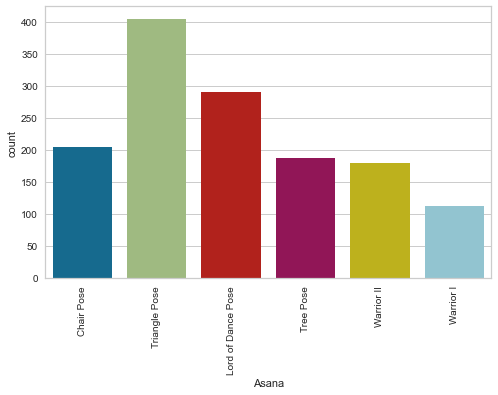

In [58]:
plt.figure(figsize=(8,5))
# plt.title("Fetal health output distribution")
plt.xlabel("Asanas")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
sb.countplot(df.Asana)
plt.show()

In [59]:
#Creating the dependent variable class
factor = pd.factorize(df['Asana'])
# df.disease = factor[0]
definitions = factor[1]
factor

(array([0, 0, 0, ..., 5, 5, 5], dtype=int64),
 Index(['Chair Pose', 'Triangle Pose', 'Lord of Dance Pose', 'Tree Pose',
        'Warrior II', 'Warrior I'],
       dtype='object'))

In [60]:
# plt.figure(figsize=(20, 10))
# dataplot = sb.heatmap(df.corr(), cmap='PiYG', annot=True)
# plt.show()
# plt.rcParams.update({'font.size': 22})

KNeighborsClassifier
Accuracy:  0.9333333333333333


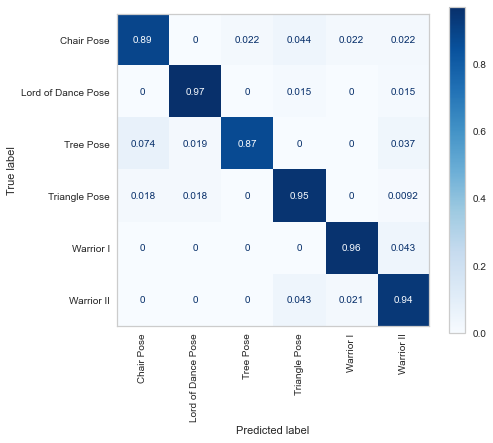


Logistic Regression
Accuracy:  0.9391304347826087


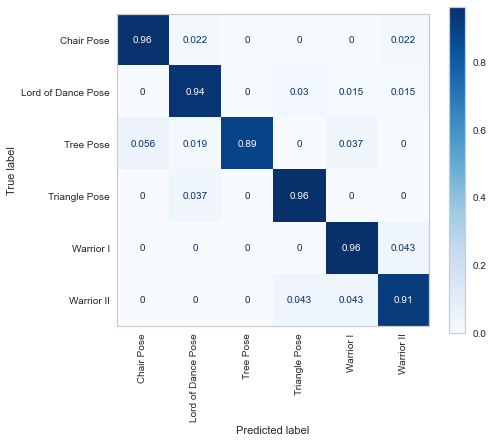


Decision Tree
Accuracy:  0.8289855072463768


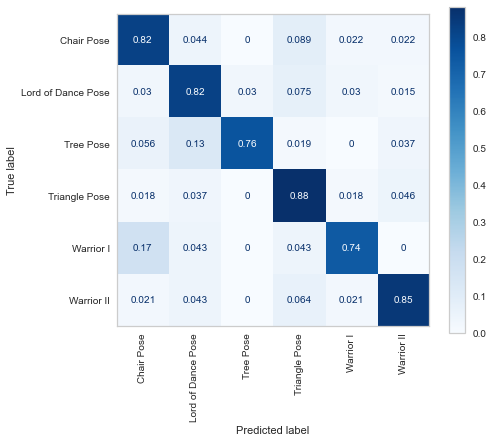


Random Forest
Accuracy:  0.9449275362318841


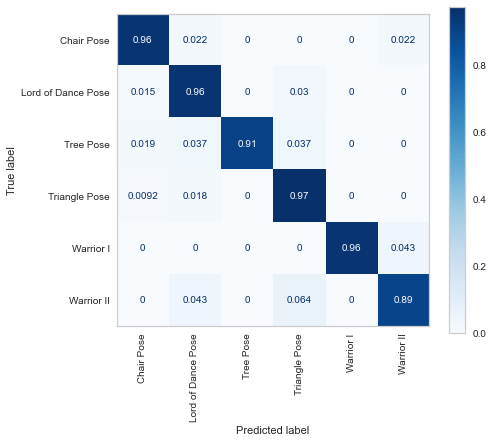


SVM
Accuracy:  0.9304347826086956


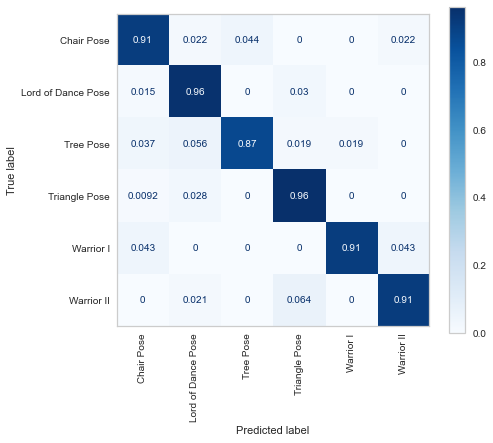


MLP
Accuracy:  0.936231884057971


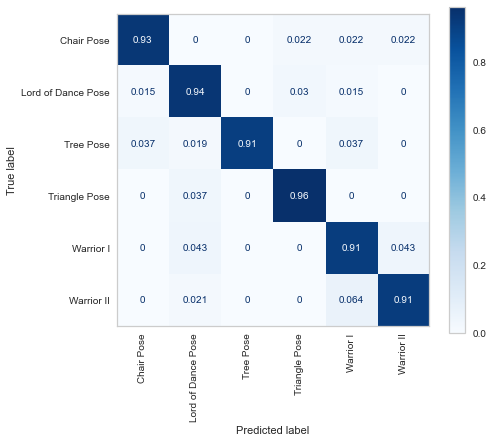


Stacked: rf and knn
Accuracy:  0.9507246376811594


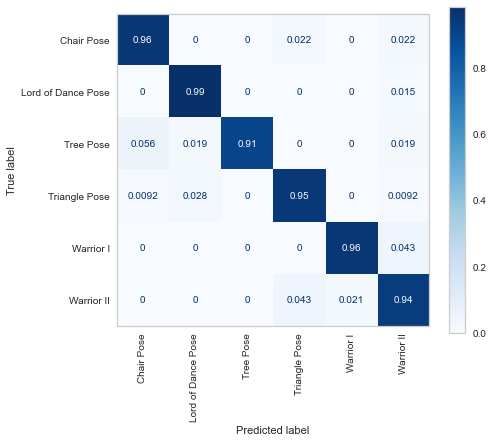

In [61]:
dataset=df
X=dataset.drop('Asana',axis=1)
y=dataset.Asana

# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

# Feature Scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

modelNames=['KNeighborsClassifier', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'MLP', 'Stacked: rf and knn']
models=[KNeighborsClassifier(),
        LogisticRegression(class_weight='balanced', max_iter=1000),
        DecisionTreeClassifier(class_weight='balanced',),
        RandomForestClassifier(class_weight='balanced', n_estimators = 200, criterion = 'gini'),
        SVC(class_weight='balanced', gamma='auto'),
        MLPClassifier(max_iter=1000),
        StackingClassifier( estimators = [('knn',models[0]),('rf',models[3])] ) ]
for i in range(0,len(models)):
    classifier=models[i].fit(X_train,y_train)
    print(modelNames[i])
    
    # Predicting the Test set results
    y_pred = classifier.predict(X_test)

    print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
    
#     model = LearningCurve(classifier, scoring='accuracy')
#     model.fit(X, y)
#     model.show()
    
    fig, ax = plt.subplots(figsize=(7,6))
    plt.grid(False)
    ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, normalize='true', cmap='Blues', ax=ax, xticks_rotation='vertical')
    plt.show()
    print()        

In [62]:
filename = 'classifier.sav'
pickle.dump(models[-1], open(filename, 'wb'))

Accuracy:  0.9507246376811594


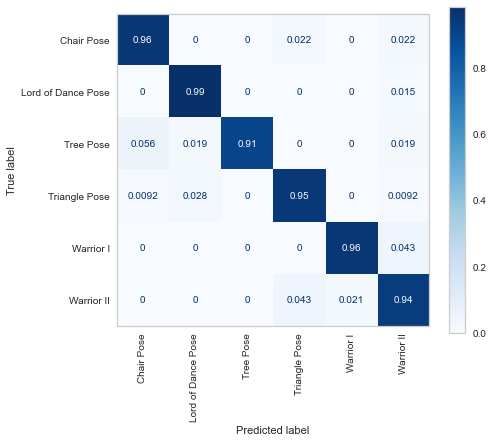

In [67]:
classifier= pickle.load(open(filename, 'rb'))
    
# Predicting the Test set results
y_pred = classifier.predict(X_test)

print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))

#     model = LearningCurve(classifier, scoring='accuracy')
#     model.fit(X, y)
#     model.show()

fig, ax = plt.subplots(figsize=(7,6))
plt.grid(False)
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test, normalize='true', cmap='Blues', ax=ax, xticks_rotation='vertical')
plt.show()

In [15]:
clf=KNeighborsClassifier(n_neighbors=12).fit(X_train,y_train)

arr=clf.kneighbors(X=X_test.iloc[0:2], return_distance=True)
arr

(array([[2.63730342, 2.70007814, 2.80376245, 2.92675264, 3.23973079,
         3.48121995, 3.75726199, 3.87120305, 3.88556384, 3.90648273,
         3.96788028, 4.03871626],
        [3.23834278, 3.90192295, 4.00338001, 4.01085804, 4.02784426,
         4.49920098, 4.61898608, 4.62449789, 4.74931881, 4.76112772,
         4.76538034, 4.81533254]]),
 array([[ 70, 937, 621, 474, 229, 388, 875, 999, 276, 714, 685, 194],
        [211, 574, 399, 867, 827, 913, 963, 772, 989, 416, 324, 283]],
       dtype=int64))

In [16]:
X_test.iloc[0]

feature_0     0.608598
feature_1     1.665643
feature_2     0.702254
feature_3     1.800048
feature_4     1.055294
                ...   
feature_61    1.354576
feature_62    0.218964
feature_63    0.982606
feature_64    0.560963
feature_65    1.489470
Name: 1323, Length: 66, dtype: float64

In [17]:
arr[0][0][0]

2.637303424434863

In [18]:
X_train.iloc[arr[1][0][0]]

feature_0     0.338742
feature_1     1.669860
feature_2     1.491694
feature_3     0.794011
feature_4     0.503629
                ...   
feature_61    1.154563
feature_62    0.082700
feature_63    0.626072
feature_64    0.633622
feature_65    1.225474
Name: 1293, Length: 66, dtype: float64

In [19]:
X_test

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65
1323,0.608598,1.665643,0.702254,1.800048,1.055294,1.923510,1.586570,1.883148,2.417209,2.279671,...,2.620205,2.166675,1.266101,2.727390,0.542075,1.354576,0.218964,0.982606,0.560963,1.489470
867,0.718409,1.888185,0.930327,0.343185,2.477335,1.170448,1.760583,2.138231,2.439604,1.558184,...,2.381974,2.072632,1.044378,1.674489,0.311534,1.975556,1.539106,1.816807,1.535176,0.630251
1124,0.659220,1.135216,1.388928,2.129731,0.605598,0.342746,1.362839,1.961413,2.074428,1.812693,...,2.911158,2.845554,0.609542,1.576188,0.163747,2.456862,1.530549,2.302158,1.366934,0.966920
282,0.389042,0.805024,1.544683,1.694527,0.426553,1.439983,0.796124,2.210731,2.588971,0.838638,...,2.819720,2.703318,0.097253,1.522465,0.402788,2.741035,1.722727,2.612173,1.320295,1.487696
323,0.849863,1.249477,1.858392,2.292806,1.229013,1.862291,1.058776,2.707397,2.447062,1.550703,...,2.403206,2.062317,0.701709,1.529457,0.469792,2.022254,1.189450,2.011486,1.392588,0.877278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,0.265781,1.733134,1.192853,1.623265,2.624399,0.464759,1.777123,2.228308,1.268902,2.004256,...,1.039918,0.770086,0.803257,2.381263,1.056664,0.303160,1.767327,0.768960,1.612618,1.824883
273,1.249849,0.498365,1.935349,2.229213,2.268446,2.250882,0.706211,1.586547,0.996712,1.201802,...,2.174889,1.505777,0.520974,0.523821,0.669605,2.657574,2.654158,1.999232,1.997943,0.011508
901,1.000085,0.918681,0.891006,2.495007,0.231702,0.397573,1.329976,2.645590,2.651302,2.638729,...,2.037924,1.323203,1.559155,2.293409,0.827451,0.479853,0.400469,0.457037,0.971477,0.796955
1143,1.173208,2.692740,1.885245,1.591578,2.232167,1.671033,2.353583,1.066614,1.456213,1.619681,...,2.861775,2.473327,0.781888,1.015682,0.390169,2.583539,2.344805,2.819031,2.626286,0.238912


In [20]:
input=df[df[df.columns[1]]==X_test.iloc[0][0]]
input

,Asana,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65
1323,Warrior I,0.608598,1.665643,0.702254,1.800048,1.055294,1.92351,1.58657,1.883148,2.417209,...,2.620205,2.166675,1.266101,2.72739,0.542075,1.354576,0.218964,0.982606,0.560963,1.48947


In [21]:
df[df[df.columns[1]]==X_train.iloc[70][0]]

,Asana,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65
1293,Warrior I,0.338742,1.66986,1.491694,0.794011,0.503629,1.015597,1.646149,2.11375,2.654755,...,2.518216,1.94247,1.375691,2.575668,0.57852,1.154563,0.0827,0.626072,0.633622,1.225474


In [22]:
df.iloc[70]

Asana         Chair Pose
feature_0       0.491326
feature_1       1.707336
feature_2       1.402971
feature_3       1.481771
                 ...    
feature_61      1.418614
feature_62      0.351518
feature_63      0.277524
feature_64       0.81379
feature_65      1.086283
Name: 70, Length: 67, dtype: object

In [23]:
print(file_names[1323],asana_names[1323])

1_42.jpg Warrior_I_Pose_or_Virabhadrasana_I


In [24]:
print(file_names[1293],asana_names[1293])

1_19.jpg Warrior_I_Pose_or_Virabhadrasana_I


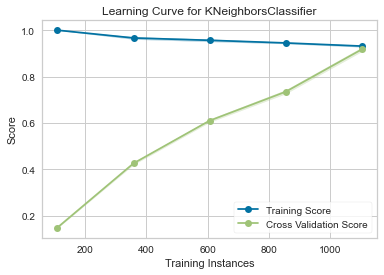

<AxesSubplot:title={'center':'Learning Curve for KNeighborsClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [25]:
model = LearningCurve(clf, scoring='accuracy')
model.fit(X, y)
model.show()

In [26]:
model.predict(X)

array(['Chair Pose', 'Chair Pose', 'Chair Pose', ..., 'Warrior I',
       'Warrior I', 'Warrior I'], dtype=object)